# Alanine Dipeptide Example with High-Level Builder API

This tutorial improves on the basic alanine example in various ways:

1. It uses neural spline transforms, which are much more expressive than affine transforms. These are implemented in the third-party package `nflows`. You need to `pip install nflows` into your conda environment in order to run this notebook.

2. It respects the domains of the ICs and the periodicity of torsions.

3. It transforms internal coordinates in a physics-informed manner. Concretely, the "slow" degrees of freedom, torsions and "fixed atoms", are generated first. Angles and bonds are conditioned on these slow degrees of freedom and added later in an autoregressive manner.

All that stuff happens under the hood of a high-level builder API.

In [1]:
import alanine_dipeptide_basics as basic
import torch
import bgflow as bg

Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


In [2]:
# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")

## Define Boltzmann Generator

Parse the prior dimensions etc. from the coordinate transform.

In [3]:
shape_info = bg.ShapeDictionary.from_coordinate_transform(basic.coordinate_transform)

In [4]:
builder = bg.BoltzmannGeneratorBuilder(
    shape_info, 
    target=basic.target_energy, 
    device=basic.device, 
    dtype=basic.dtype
)

The builder class uses reasonable default choices for the transforms and conditioner networks but it's customizable. If you want to tinker with the settings, take a look at the documentation.

For example each `add_condition` call can take various keyword arguments that specify the depth and width of the conditioner network, the transformer type, etc. To change the dimension and number of hidden layers in a conditioner, try something like `builder.add_condition(TORSION, on=FIXED, hidden=(32,64,32))`.

In [5]:
from bgflow import TORSIONS, FIXED, BONDS, ANGLES

In [6]:
for i in range(4):
    builder.add_condition(TORSIONS, on=FIXED)
    builder.add_condition(FIXED, on=TORSIONS)
for i in range(2):
    builder.add_condition(BONDS, on=ANGLES)
    builder.add_condition(ANGLES, on=BONDS)
builder.add_condition(ANGLES, on=(TORSIONS, FIXED))
builder.add_condition(BONDS, on=(ANGLES, TORSIONS, FIXED))
builder.add_map_to_ic_domains()
builder.add_map_to_cartesian(basic.coordinate_transform)
generator = builder.build_generator()

In [7]:
# TEST
# play forward and backward
samples = generator.sample(2)
energy = generator.energy(samples)
generator.kldiv(10)

tensor([[ 640620.2500],
        [ 508778.7188],
        [ 382282.2812],
        [ 544364.1250],
        [ 553774.8125],
        [1187378.7500],
        [ 579557.5000],
        [ 540659.0625],
        [ 627307.0625],
        [ 440060.5312]], device='cuda:0', grad_fn=<SubBackward0>)

## Train

In [8]:
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False
)

In [9]:
if main:
    nll_trainer.train(
        n_iter=1000, 
        data=basic.training_data,
        batchsize=128,
        n_print=100, 
        w_energy=0.0
    )

1	NLL: -13.2985	
101	NLL: -196.1384	
201	NLL: -203.5495	
301	NLL: -205.2721	
401	NLL: -205.7857	
501	NLL: -205.7383	
601	NLL: -206.5627	
701	NLL: -205.3726	
801	NLL: -208.3383	
901	NLL: -207.7665	


## Plot

In [10]:
from matplotlib import pyplot as plt

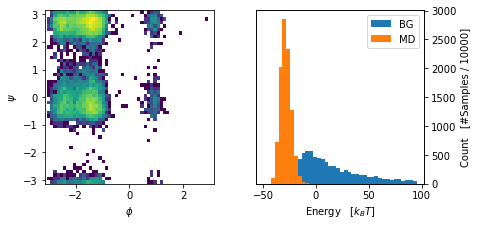

In [11]:
if main:
    
    n_samples = 10000
    samples = generator.sample(n_samples)

    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    fig.tight_layout()

    basic.plot_phi_psi(axes[0], samples, basic.system)
    basic.plot_energies(axes[1], samples, basic.target_energy, basic.test_data)

    del samples